In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
import scipy
import math
import random
import sklearn
import nltk
import warnings
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc

In [3]:
path="D:/CDS513/Assignment 1/input"
    
os.chdir(path)

# Read csv data file
# Data without feature standardization
df = pd.read_csv('Data_final_description.csv')

In [4]:
df

,User-id,Game-id,Game-title,Genre,personal-rating,description
0,5250,96,Alien Swarm,Shooter,3,Alien Swarm is a game and Source SDK release f...
1,975449,96,Alien Swarm,Shooter,5,Alien Swarm is a game and Source SDK release f...
2,1950243,96,Alien Swarm,Shooter,3,Alien Swarm is a game and Source SDK release f...
3,2259650,96,Alien Swarm,Shooter,2,Alien Swarm is a game and Source SDK release f...
4,2753525,96,Alien Swarm,Shooter,2,Alien Swarm is a game and Source SDK release f...
...,...,...,...,...,...,...
42241,287824954,462,Close Your Eyes,Puzzle,5,Close Your Eyes is a puzzle horror game where ...
42242,293303005,100,All Is Dust,Role-playing (RPG),5,Dust off the vacuum and tidy up with The Sims ...
42243,300248088,2093,Sigils of Elohim,Puzzle,5,"As if awakening from a deep sleep, you find yo..."
42244,306839937,2029,Secret Files Tunguska,Point-and-click,5,Unravel one of the greatest mysteries of our t...


# Finding # of interaction

In [5]:
users_interactions_count_df = df.groupby(['User-id', 'Game-title']).size().groupby('User-id').size()
print('# users: %d' % len(users_interactions_count_df))

users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5]\
                                    .reset_index()[['User-id']]


users_with_few_interactions_df = users_interactions_count_df[users_interactions_count_df < 3]\
                                    .reset_index()[['User-id']]

print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))
print('# users with less than 3 interactions: %d' % len(users_with_few_interactions_df))

# users: 8470
# users with at least 5 interactions: 1717
# users with less than 3 interactions: 5937


In [6]:
interactions_from_selected_users_df = df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'User-id',
               right_on = 'User-id')

interactions_from_few_selected_users_df = df.merge(users_with_few_interactions_df, 
               how = 'right',
               left_on = 'User-id',
               right_on = 'User-id')

print('# of interactions from all users: %d' % len(df))
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))
print('# of interactions from users with less than 3 interactions: %d' % len(interactions_from_few_selected_users_df))

# of interactions from all users: 42246
# of interactions from users with at least 5 interactions: 32535
# of interactions from users with less than 3 interactions: 6935


# Split Dataset for training and testing

In [7]:
interactions_train_df, interactions_test_df = train_test_split(interactions_from_selected_users_df,
                                   stratify=interactions_from_selected_users_df['User-id'],
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 26028
# interactions on Test set: 6507


In [8]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_from_selected_users_df.set_index('User-id')
interactions_train_indexed_df = interactions_train_df.set_index('User-id')
interactions_test_indexed_df = interactions_test_df.set_index('User-id')

In [9]:
def get_items_interacted(UserID, interactions_df):
    # Get the user's data and merge in the game information.
    interacted_items = interactions_df.loc[UserID]['Game-id']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

# Top-N accuracy metrics

In [10]:

EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:
    def get_not_interacted_items_sample(self, UserID, sample_size, seed=42):
        interacted_items = get_items_interacted(UserID, interactions_full_indexed_df)
        all_items = set(df['Game-id'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, UserID):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[UserID]
        
        if isinstance(interacted_values_testset['Game-id'], pd.Series):
            user_interacted_items_testset = set(interacted_values_testset['Game-id'])
        else:
            # This handles the case where 'Game-id' is a single numpy.int32 element by wrapping it in a list
            user_interacted_items_testset = set([interacted_values_testset['Game-id']])
        
        interacted_items_count_testset = len(user_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        user_recs_df = model.recommend_items(UserID, 
                                               items_to_ignore=get_items_interacted(UserID, 
                                                                                    interactions_train_indexed_df), 
                                                                                    topn=10000000000,metric=1)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in user_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(UserID, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS)

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = user_recs_df[user_recs_df['Game-id'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['Game-id'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        user_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return user_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, UserID in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            user_metrics = self.evaluate_model_for_user(model, UserID)  
            user_metrics['UserID'] = UserID
            people_metrics.append(user_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()

In [11]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['User-id', 'Game-id'])['personal-rating'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 32535


,User-id,Game-id,personal-rating
0,76767,65,1.584963
1,76767,370,2.584963
2,76767,380,2.584963
3,76767,382,2.000000
4,76767,385,2.584963
5,76767,515,2.584963
6,76767,518,1.000000
7,76767,520,1.000000
8,76767,1765,2.321928
9,76767,1914,2.000000


In [12]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_full_df.pivot(index='User-id', 
                                                          columns='Game-id', 
                                                          values='personal-rating').fillna(0)

users_items_pivot_matrix_df

Game-id,0,1,2,3,4,5,6,7,8,9,...,2788,2789,2790,2791,2792,2794,2795,2796,2798,2799
User-id,,,,,,,,,,,,,,,,,,,,,
76767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
554278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285869008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
286926470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
288274882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[76767,
 86540,
 229911,
 298950,
 554278,
 561758,
 748719,
 975449,
 1129452,
 1612666]

In [15]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<1717x2511 sparse matrix of type '<class 'numpy.float64'>'
	with 32535 stored elements in Compressed Sparse Row format>

In [16]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [17]:
U.shape

(1717, 15)

In [18]:
Vt.shape

(15, 2511)

In [19]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [20]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 3.97885691e-02, -1.77488185e-03,  8.71733542e-03, ...,
        -2.61336757e-02,  1.52553551e-02,  5.04950759e-03],
       [-6.32641198e-03, -3.99564845e-05,  4.37639945e-03, ...,
        -6.07548448e-03, -3.55345642e-02,  2.63852355e-03],
       [ 2.59739937e-02, -2.35877725e-03,  8.22512163e-03, ...,
        -2.19672927e-02,  1.50559974e-02,  4.19291027e-03],
       ...,
       [ 5.99107356e-03,  1.11493943e-03, -7.73534982e-05, ...,
        -1.10400186e-02,  5.91609110e-02,  4.15358837e-03],
       [ 2.03092123e-02,  1.28411408e-03, -3.62859123e-03, ...,
         5.31183261e-02,  3.06753769e-02,  6.78107978e-03],
       [ 2.95065865e-03,  3.85804836e-03, -1.11399751e-02, ...,
        -1.26088763e-02,  9.50502921e-02,  9.76171179e-03]])

In [21]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,76767,86540,229911,298950,554278,561758,748719,975449,1129452,1612666,...,281535206,282464648,283872900,285386664,285860790,285869008,286926470,288274882,293042025,294620986
Game-id,,,,,,,,,,,,,,,,,,,,,
0,0.384574,0.379348,0.383009,0.378346,0.380448,0.392079,0.375094,0.394736,0.379145,0.378432,...,0.378166,0.380570,0.377286,0.380854,0.378102,0.378731,0.380327,0.380744,0.382367,0.380399
1,0.379864,0.380060,0.379798,0.380855,0.380123,0.379894,0.380228,0.379904,0.380603,0.379903,...,0.380690,0.380146,0.379857,0.379956,0.379778,0.380130,0.380066,0.380191,0.380210,0.380502
2,0.381053,0.380561,0.380997,0.383389,0.380550,0.383302,0.379174,0.385706,0.380725,0.380946,...,0.380128,0.380461,0.380013,0.380135,0.381239,0.379786,0.379983,0.380056,0.379654,0.378802
3,0.378773,0.380827,0.378878,0.380372,0.380093,0.378097,0.380239,0.378741,0.379636,0.380689,...,0.380599,0.380256,0.380058,0.380069,0.379578,0.380186,0.379911,0.380259,0.380994,0.381027
4,0.381647,0.381733,0.378689,0.372623,0.379748,0.380630,0.382410,0.386776,0.379680,0.382790,...,0.380492,0.379776,0.385137,0.380173,0.386214,0.381506,0.381496,0.381556,0.380768,0.378871
5,0.379962,0.381758,0.376449,0.378498,0.379613,0.380967,0.380323,0.386513,0.378296,0.382876,...,0.378323,0.380192,0.380660,0.380171,0.383760,0.380707,0.381620,0.381228,0.378593,0.379230
6,0.380430,0.382124,0.378905,0.368998,0.379458,0.381944,0.380633,0.385023,0.380605,0.379744,...,0.379560,0.379923,0.382414,0.379846,0.383331,0.380780,0.381405,0.381402,0.379509,0.379303
7,0.380132,0.379910,0.380115,0.380073,0.379994,0.380010,0.379969,0.380396,0.380057,0.380158,...,0.380062,0.380065,0.380207,0.380241,0.380081,0.380042,0.380082,0.380107,0.380203,0.380087
8,0.378535,0.380377,0.376583,0.375432,0.381326,0.379951,0.380633,0.389976,0.379974,0.382480,...,0.378838,0.379482,0.381081,0.379688,0.384731,0.380809,0.381549,0.380081,0.378716,0.378618


In [22]:
len(cf_preds_df.columns)

1717

In [23]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False, metric=0):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})
        
        # Local model recommendation use
        if(metric==0):
            ignore_interacted_items = self.items_df[self.items_df['User-id'] == user_id]['Game-id'].tolist()
        
        # Recommend the highest predicted rating movies that the user hasn't seen yet.
            recommendations_df = sorted_user_predictions[~sorted_user_predictions['Game-id'].isin(ignore_interacted_items)] \
                                   .sort_values('recStrength', ascending = False) \
                                   .head(topn)
        # Global Metric Evaluation use
        elif(metric==1):
            recommendations_df = sorted_user_predictions[~sorted_user_predictions['Game-id'].isin(items_to_ignore)] \
                                   .sort_values('recStrength', ascending = False) \
                                   .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'Game-id', 
                                                          right_on = 'Game-id')[['recStrength', \
                                                                                   'Game-id', \
                                                                                   'Game-title', \
                                                                                   'Genre', \
                                                                                   'description']]

        #return self.items_df
        return recommendations_df.drop_duplicates()
    
cf_recommender_model = CFRecommender(cf_preds_df, df)

In [24]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...


C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_28684\1185992867.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sa

1716 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.7427385892116183, 'recall@10': 0.8484708775165206}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,UserID
106,61,61,61,1.000000,1.000000,62990992
63,49,49,49,1.000000,1.000000,138941587
133,18,27,36,0.500000,0.750000,11403772
50,31,33,35,0.885714,0.942857,49893565
33,32,33,35,0.914286,0.942857,48798067
45,27,33,34,0.794118,0.970588,24469287
31,9,17,32,0.281250,0.531250,116876958
149,14,18,30,0.466667,0.600000,47457723
109,24,28,29,0.827586,0.965517,11373749
119,26,27,27,0.962963,1.000000,10599862


In [25]:
def inspect_interactions(user_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df.sort_values(by='personal-rating', ascending=False)
    else:
        interactions_df = interactions_train_indexed_df.sort_values(by='personal-rating', ascending=False)
    return interactions_df.loc[user_id]

In [26]:
inspect_interactions(11403772, test_set=False).head(10)

,Game-id,Game-title,Genre,personal-rating,description
User-id,,,,,
11403772,1244,Ironclad Tactics,Real Time Strategy (RTS),5,"Ironclad Tactics is a fast-paced, card-based t..."
11403772,983,Freedom Planet,Platform,5,Freedom Planet is a combat-based platform adve...
11403772,2334,Team Fortress 2,Shooter,5,The WAR! Update was a class update for the Dem...
11403772,470,Coffin Dodgers,Racing,5,Coffin Dodgers sees you take on the role of sa...
11403772,1980,SUPER DISTRO,Adventure,5,"""Super Distro"" is a hard-as-nails 2D platforme..."
11403772,1138,Hard Reset,Shooter,5,The acclaimed First-Person Shooter returns ful...
11403772,1424,Magic Duels,Strategy,5,Join tens of millions of Magic: The Gathering ...
11403772,2046,Shadow Warrior Classic Redux,Shooter,5,The definitive version of the cult classic sho...
11403772,1829,RAGE,Shooter,5,Rage is a first-person shooter set in the not-...


In [27]:
cf_recommender_model.recommend_items(11403772,topn=10, verbose=True)

,recStrength,Game-id,Game-title,Genre,description
0,0.698168,1120,Half-Life 2,Shooter,This mod is to run Half-Life 2: Update (itself...
255,0.553001,682,Dishonored,Puzzle,Dishonored is an immersive first-person action...
374,0.535893,656,Deus Ex Human Revolution,Shooter,In Deus Ex: Human Revolution you play Adam Jen...
476,0.523938,2585,Trine 2,Platform,Three Heroes survive in countless dangers in a...
561,0.501098,586,Darksiders II,Role-playing (RPG),Become Death - The most feared of the legendar...
615,0.500853,2132,Sniper Elite V2,Shooter,Sniper Elite V2 is the eagerly-awaited sequel ...
728,0.499099,1175,Hitman Absolution,Shooter,Hitman: Absolution follows the Original Assass...
844,0.497620,410,Castle Crashers,Puzzle,This four player RPG adventure will let you ha...
944,0.496371,2483,The Witcher 2 Assassins of Kings Enhanced Edition,Role-playing (RPG),All existing owners of The Witcher 2 received ...
1062,0.494837,317,Borderlands The Pre-Sequel,Shooter,Shoot 'n' loot your way through a brand new ad...


In [28]:
def gather_scores_and_labels_cf(model, test_data, all_game_ids):
    y_true = []
    y_scores = []

    # Iterate through each user in the test set
    for user_id in test_data['User-id'].unique():
        # Actual interactions from test data
        actual_interactions = set(test_data[test_data['User-id'] == user_id]['Game-id'])
        
        # Predict scores for all items using the CF model
        # Get user predictions and filter by all_game_ids to include only relevant items
        if user_id in model.cf_predictions_df.columns:
            user_predictions = model.cf_predictions_df[user_id].reset_index()
            user_predictions.columns = ['Game-id', 'recStrength']
        else:
            # If no predictions exist for a user, use zero scores
            user_predictions = pd.DataFrame(all_game_ids, columns=['Game-id'])
            user_predictions['recStrength'] = 0

        user_predictions = user_predictions[user_predictions['Game-id'].isin(all_game_ids)]

        # Merge true labels and predicted scores
        all_items_df = pd.DataFrame(all_game_ids, columns=['Game-id'])
        all_items_df = all_items_df.merge(user_predictions, on='Game-id', how='left').fillna(0)
        
        # True labels: 1 if item was interacted with, 0 otherwise
        all_items_df['true_label'] = all_items_df['Game-id'].apply(lambda x: 1 if x in actual_interactions else 0)
        
        y_true.extend(all_items_df['true_label'])
        y_scores.extend(all_items_df['recStrength'])

    return y_true, y_scores

In [29]:
all_game_ids = df['Game-id'].unique()  # Extracting all game IDs from the items dataframe
y_true, y_scores = gather_scores_and_labels_cf(cf_recommender_model, interactions_test_df, all_game_ids)

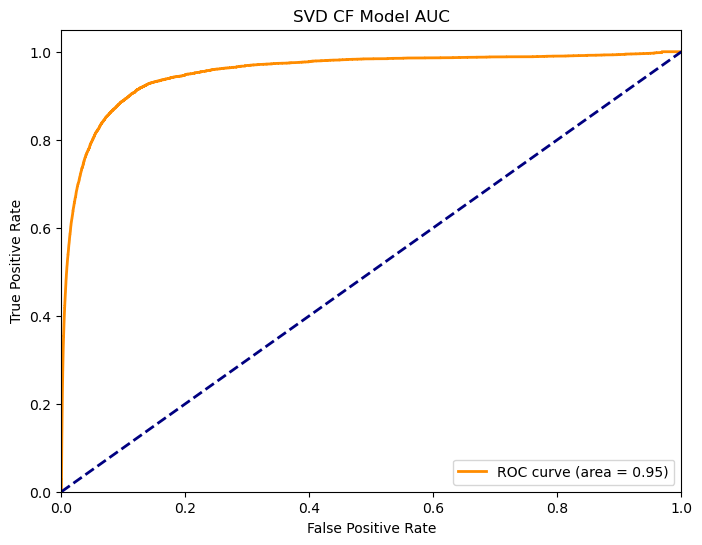

In [30]:
# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVD CF Model AUC')
plt.legend(loc="lower right")
plt.show()